In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install vaderSentiment

In [3]:
#import sys
#sys.path.append('/content/drive/MyDrive/notebook_data')
#!pip install -r /content/drive/MyDrive/notebook_data/requirements.txt
#from preprocess import preprocess_dataframe, preprocess_dataframe_sw
import numpy as np
import pandas as pd
import joblib

In [ ]:
#df = pd.read_csv('/content/drive/MyDrive/notebook_data/datasets/merged-labeled-reduced.tsv',sep='\t') # assuming column called ['text']
#df.drop(['id', 'author', 'handle', 'timestamp', 'query'], axis=1, inplace=True)
#df.head()

In [ ]:
#df = preprocess_dataframe_sw(df)
#df.dropna(inplace=True)
#df['label'].value_counts()

In [4]:
#df.to_csv('/content/drive/MyDrive/notebook_data/datasets/merged-labeled-reduced-cleaned_sw.tsv', sep='\t', index=False)
df = pd.read_csv('/content/drive/MyDrive/notebook_data/datasets/merged-labeled-reduced-cleaned_sw.tsv',sep='\t') # assuming column called ['text']
df.dropna(inplace=True)
df.head()

,text,label,cleaned
0,#EartthquakeReport #TsunamiReport for M7.2 #Ea...,earthquake,eartthquakereport tsunamireport for m72 earthq...
1,Tsunami warning lifted after earthquake off Al...,earthquake,tsunami warning lifted after earthquake off al...
2,"First Temblor map (AFAIK) on bluesky! Today, a...",earthquake,first temblor map afaik on bluesky today a mag...
3,\U0001f9ea\n\nA M7.2 earthquake occurred offsh...,earthquake,test tube a m72 earthquake occurred offshore a...
4,Earthquake waves from the M7.2 earthquake in A...,earthquake,earthquake waves from the m72 earthquake in al...


In [5]:
df['label'].value_counts()

,count
label,
earthquake,5654
wildfire,5611
other,4973
hurricane,4746
flood,3312
tornado,765


In [6]:
# Add some more columns
import spacy
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to categorize sentiment
def get_sentiment(text):
    sentiment_score = analyzer.polarity_scores(text)['compound']

    # Categorize sentiment based on the score
    if sentiment_score >= 0.05:
        return 0 # positive
    elif sentiment_score <= -0.05:
        return 1 # negative
    else:
        return 2 # neutral


nlp = spacy.load("en_core_web_sm")

def has_location(text):
    """Checks if a location is mentioned in the text using spaCy's NER."""
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_ == "GPE":
            if not re.search(r"[^a-zA-Z\s.,]", ent.text):
              return 1
    return 0

def text_length(text):
    """Categorizes the length of the text."""
    doc = nlp(text)
    tokens = [token for token in doc if not token.is_punct]
    if len(tokens) < 10: # short
        return 0
    elif len(tokens) < 20: # medium
        return 1
    else:
        return 2 # long


In [7]:
df['has_location'] = df['text'].apply(has_location)
df['text_length'] = df['text'].apply(text_length)
df['sentiment'] = df['text'].apply(get_sentiment)

In [8]:
df.to_csv('/content/drive/MyDrive/notebook_data/datasets/merged-labeled-reduced-cleaned_sw_features_v2.tsv', sep='\t', index=False)

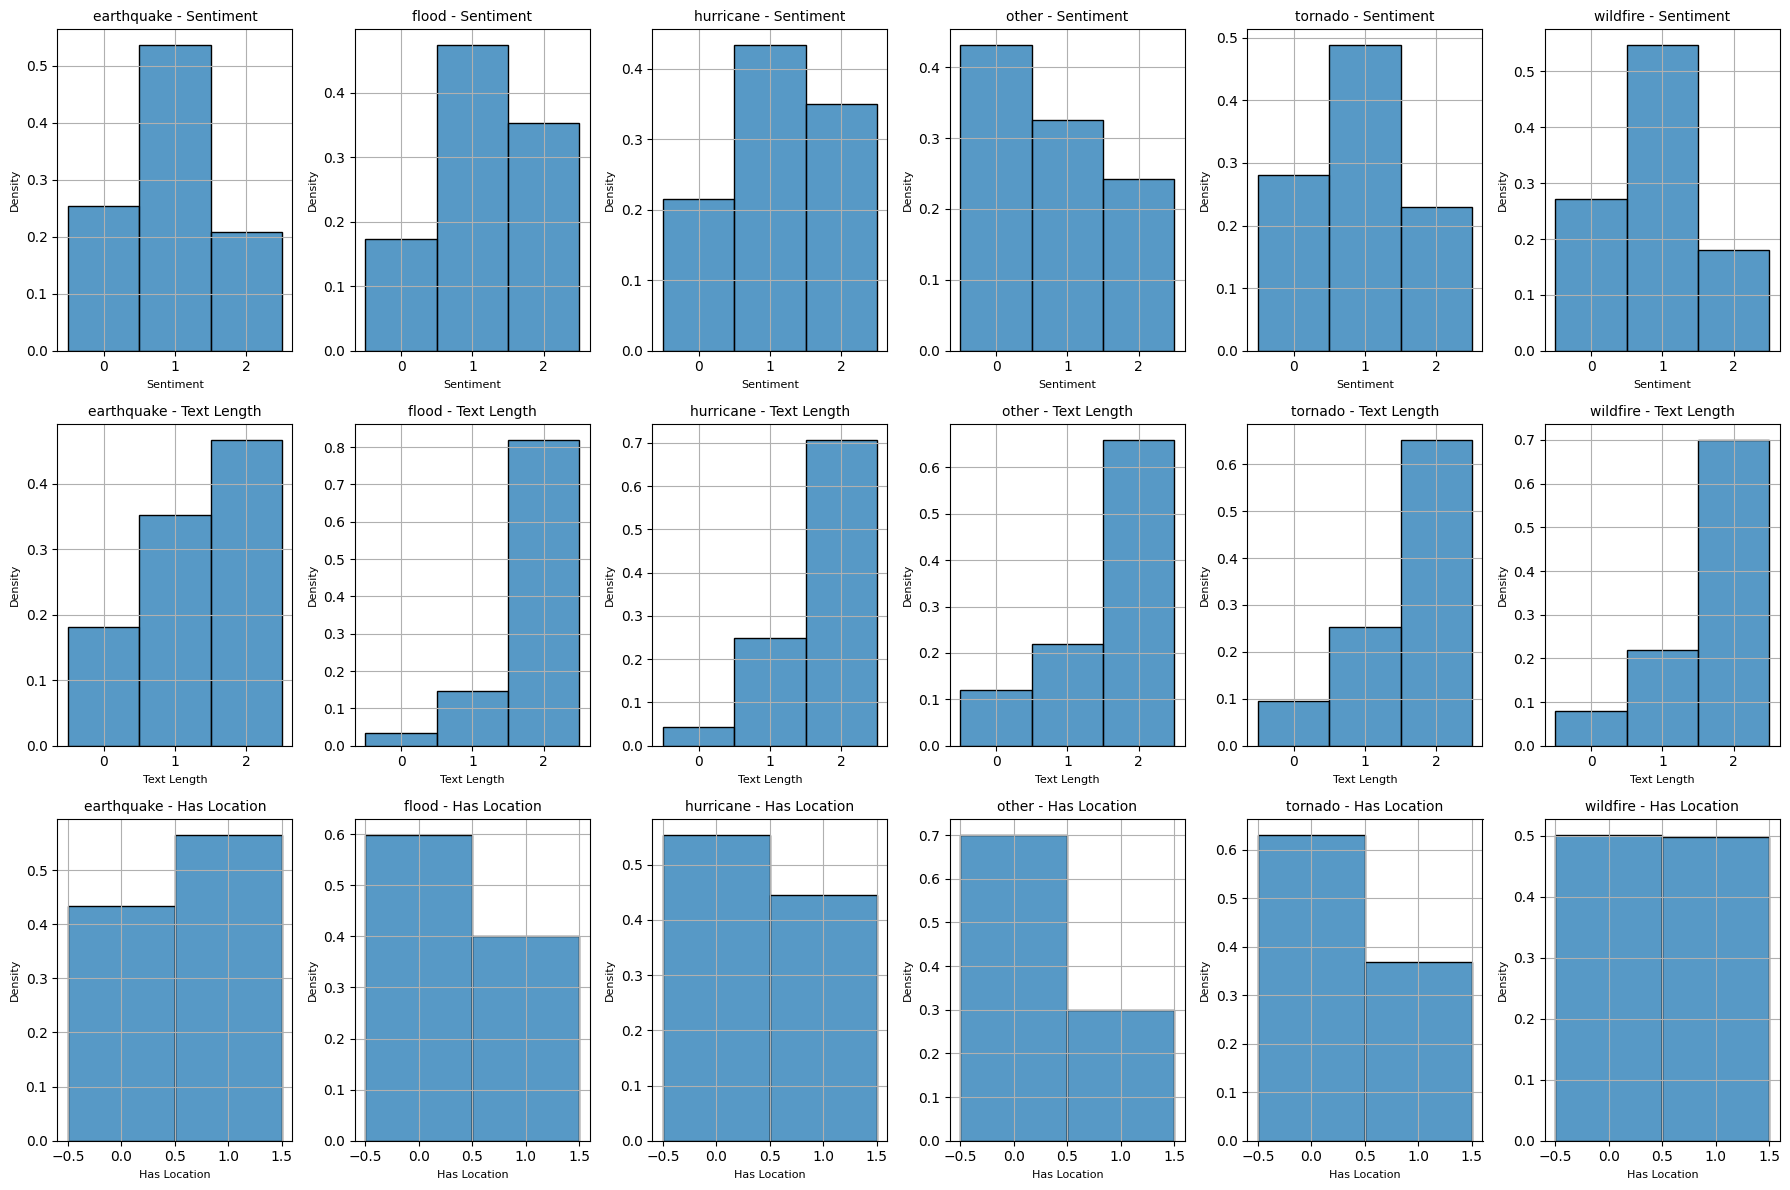

In [19]:
# Show some graphical comparisons between labels for the new features
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the data by disaster category
categories = ['earthquake', 'flood', 'hurricane', 'other', 'tornado', 'wildfire']
filtered_data = {category: df[df['label'] == category] for category in categories}

# Create the figure and subplots (3 rows, 6 columns for 18 plots)
fig, axes = plt.subplots(3, 6, figsize=(18, 12))

# Features to plot
features = ['sentiment', 'text_length', 'has_location']
feature_titles = ['Sentiment', 'Text Length', 'Has Location']

# Loop over the features and categories to create the plots
for row_idx, feature in enumerate(features):
    for col_idx, category in enumerate(categories):
        ax = axes[row_idx, col_idx]  # Select the correct subplot

        data = filtered_data[category]  # Get the data for the current category

        if feature == 'has_location':
            sns.histplot(data[feature], kde=False, label=category, stat='density', discrete=True, bins=2, ax=ax)
        else:
            sns.histplot(data[feature], kde=False, label=category, stat='density', discrete=True, bins=3, ax=ax)

        # Set the title, x-label, and y-label for each plot
        ax.set_title(f'{category} - {feature_titles[row_idx]}', fontsize=10)
        ax.set_xlabel(feature_titles[row_idx], fontsize=8)
        ax.set_ylabel('Density', fontsize=8)

        # Add a grid
        ax.grid(True)

# Adjust layout for spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [20]:
# Based on the results, let's drop the text length category and stick with locations and sentiment

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# train test split with features
X_features = df[['cleaned', 'has_location', 'sentiment']]
X_regular = df['cleaned']
y = df['label']

# Encode string labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Converts labels to numeric form
print(f"Labels before conversion: {np.unique(y)}")
print(f"Labels after conversion: {np.unique(y_encoded)}")

X_trainf, X_testf, y_trainf, y_testf = train_test_split(X_features, y_encoded, test_size=0.2, stratify=y_encoded, random_state=24)
X_train, X_test, y_train, y_test = train_test_split(X_regular, y_encoded, test_size=0.2, stratify=y_encoded, random_state=24)

print(f"Training with {len(X_trainf)} feature tagged samples; Testing with {len(X_testf)} feature tagged samples")
print(f"Training with {len(X_train)} non tagged samples; Testing with {len(X_test)} non tagged samples")

unique_vals, counts = np.unique(y_train, return_counts=True)
unique_vals_test, counts_test = np.unique(y_test, return_counts=True)
print(f"Class distribution in training: {dict(zip(unique_vals.tolist(), counts.tolist()))}")
print(f"Class distribution in testing: {dict(zip(unique_vals_test.tolist(), counts_test.tolist()))}")


Labels before conversion: ['earthquake' 'flood' 'hurricane' 'other' 'tornado' 'wildfire']
Labels after conversion: [0 1 2 3 4 5]
Training with 20048 feature tagged samples; Testing with 5013 feature tagged samples
Training with 20048 non tagged samples; Testing with 5013 non tagged samples
Class distribution in training: {0: 4523, 1: 2649, 2: 3797, 3: 3978, 4: 612, 5: 4489}
Class distribution in testing: {0: 1131, 1: 663, 2: 949, 3: 995, 4: 153, 5: 1122}


In [21]:
# export the train and test splits, along with the label_encoder and tfidf vectorizer
joblib.dump((X_train, y_train, X_test, y_test), '/content/drive/MyDrive/notebook_data/exports/train_test/train_test_split_v4.pkl')
joblib.dump((X_trainf, y_trainf, X_testf, y_testf), '/content/drive/MyDrive/notebook_data/exports/train_test/train_test_split_features_v2.pkl')
joblib.dump(label_encoder, '/content/drive/MyDrive/notebook_data/exports/labelEncoder_tfidfVectorizer/label_encoder_v4.pkl')

['/content/drive/MyDrive/notebook_data/exports/labelEncoder_tfidfVectorizer/label_encoder_v4.pkl']